In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [72]:
data = pd.read_excel('../data_archives/df_processed.xlsx')
data = data[data['WeekTotals']>0].reset_index()
data_labels = data[['name','mapped_venue_type','lat','long']]
data = data.drop(['index','lat','long','google_id','venue_type','WeekTotals','name','mapped_venue_type','level_0','activity_cluster'],axis=1)
print("Business/Venue dataset has {} records with {} features each".format(*data.shape))
data.head()

Business/Venue dataset has 1723 records with 7 features each


Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
0     443      531        506       519     514       144      40
1     443      531        506       519     514       144      40
2     443      531        506       519     514       144      40
3     443      531        506       519     514       144      40
4     443      531        506       519     514       144      40

In [73]:
display(data.describe())

Monday      Tuesday    Wednesday     Thursday       Friday  \
count  1723.000000  1723.000000  1723.000000  1723.000000  1723.000000   
mean    379.543819   412.717353   407.250145   438.252467   497.770749   
std     176.533785   195.476881   185.133268   170.967621   170.640017   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%     242.000000   236.000000   249.000000   297.000000   387.000000   
50%     357.000000   387.000000   396.000000   401.000000   461.000000   
75%     443.000000   531.000000   506.000000   519.000000   514.000000   
max    1122.000000  1196.000000  1158.000000  1233.000000  1353.000000   

          Saturday       Sunday  
count  1723.000000  1723.000000  
mean    371.404527   270.431805  
std     215.107030   213.675578  
min       0.000000     0.000000  
25%     144.000000    40.000000  
50%     429.000000   334.000000  
75%     429.000000   334.000000  
max    1139.000000  1071.000000

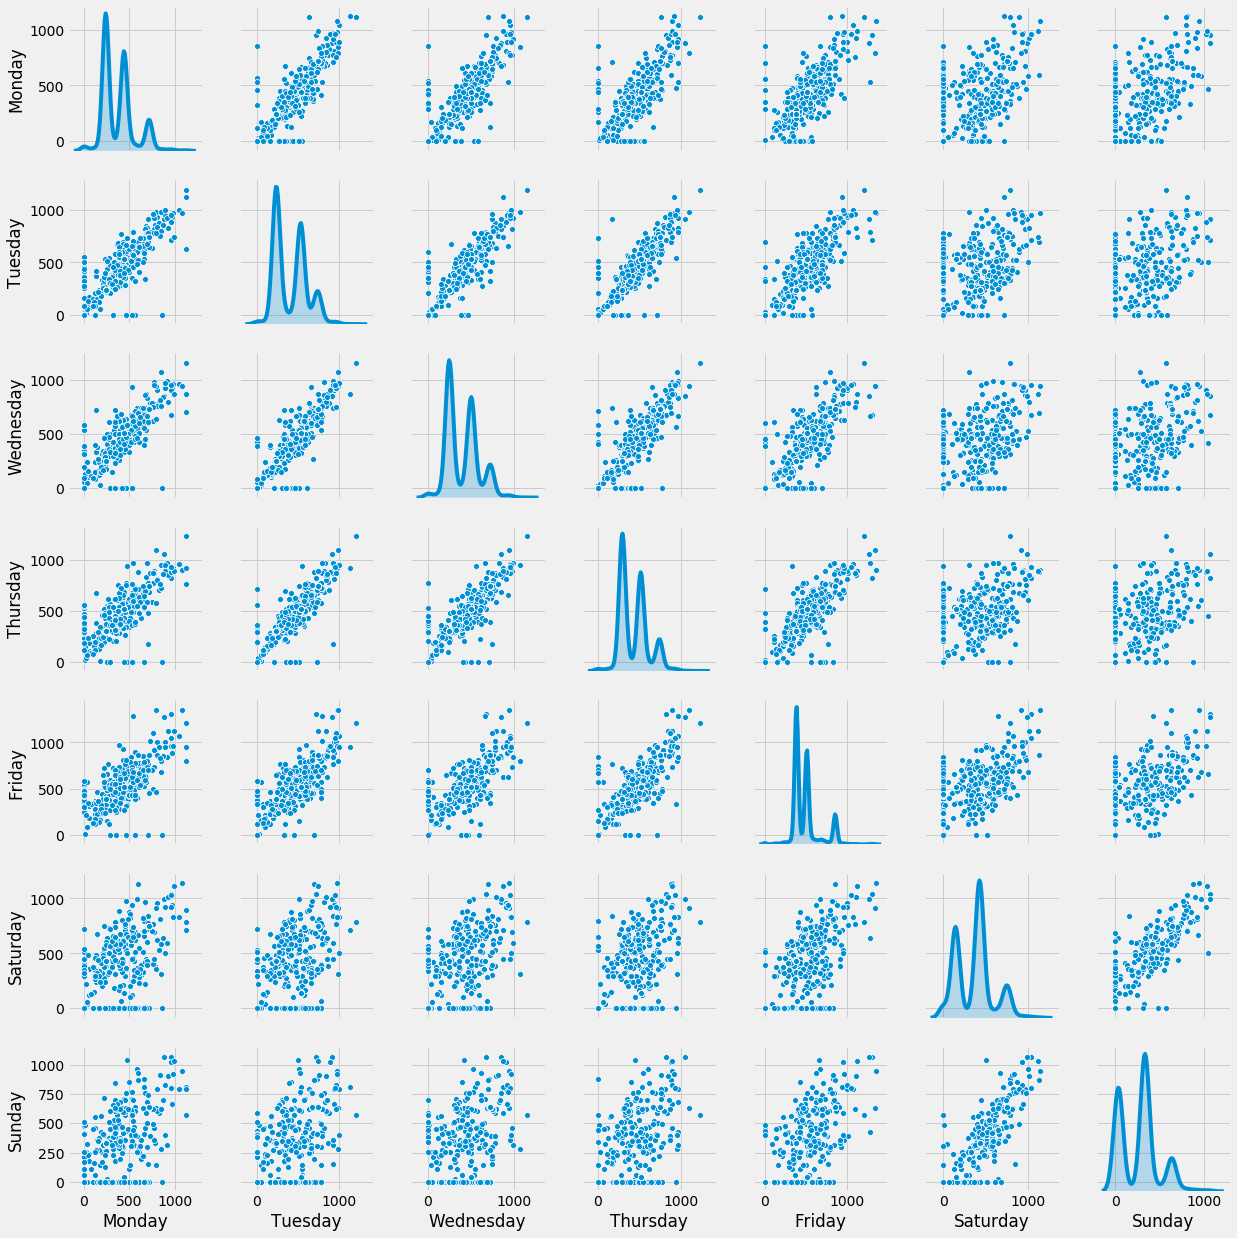

In [74]:
import seaborn as sns
sns.pairplot(data=data, diag_kind='kde')

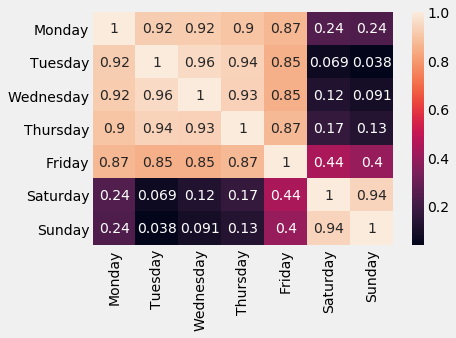

In [75]:
sns.heatmap(data.corr(), annot=True)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


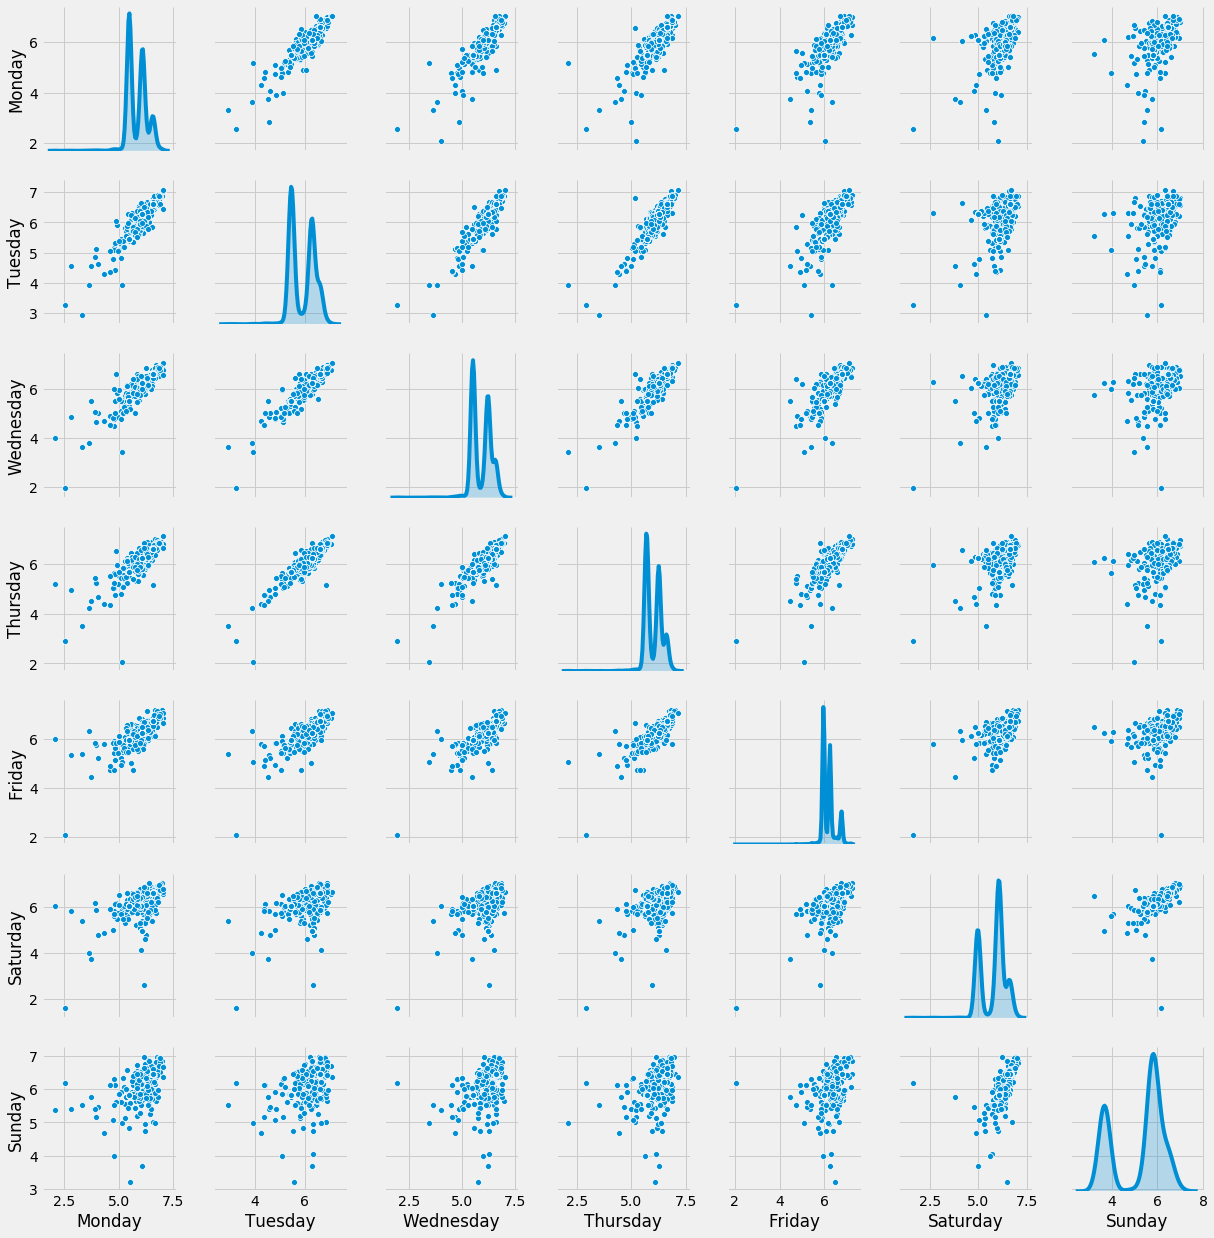

In [76]:
log_data = np.log(data)
sns.pairplot(log_data, diag_kind='kde')

## PCA Dimmensionality Reduction

In [77]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(data)

reduced_data = pca.transform(data)

reduced_data = pd.DataFrame(reduced_data, columns=['Dimension_1','Dimension_2'])

Text(0.5,1,'PC plane with original feature projections.')

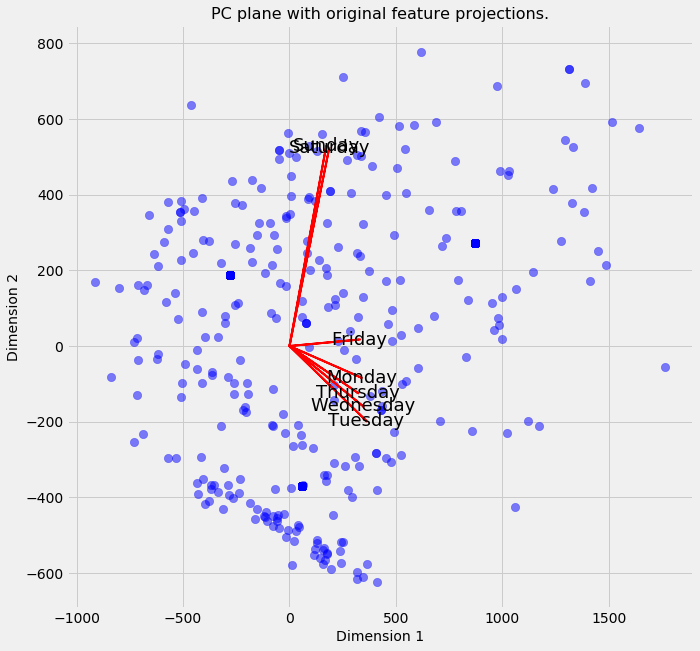

In [78]:
fig, ax = plt.subplots(figsize=(10,10))

#scatterplot of reduced data
ax.scatter(x=reduced_data.loc[:,'Dimension_1'],y=reduced_data.loc[:,'Dimension_2'],facecolors='b',edgecolors='b',
          s=70, alpha=0.5)

feature_vectors = pca.components_.T

arrow_size, text_pos = 800.0, 800.0

for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, data.columns[i], color='black', 
                 ha='center', va='center', fontsize=18)
        
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 2", fontsize=14)
ax.set_title("PC plane with original feature projections.", fontsize=16)

## KMeans Clustering

In [79]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

KMeans_clusterer = KMeans(n_clusters=4).fit(reduced_data)

preds = KMeans_clusterer.predict(reduced_data)

centers = KMeans_clusterer.cluster_centers_

score = silhouette_score(reduced_data, preds)
print("KMeans Clusters with a silhouette score of:",score)

KMeans Clusters with a silhouette score of: 0.853580216853


Text(0.5,1,'Cluster Learning on PCA_Reduced Data')

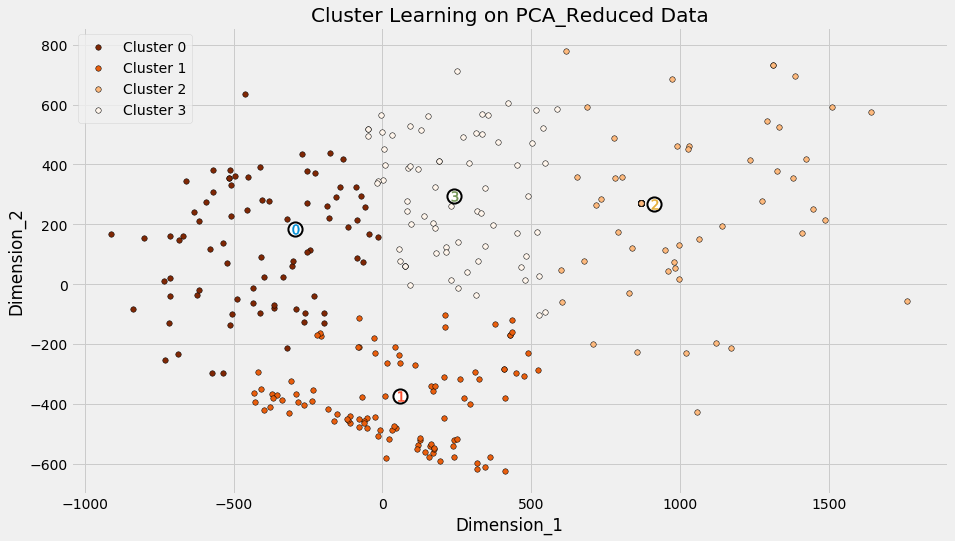

In [80]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=(14,8))

predictions = pd.DataFrame(preds, columns=['Cluster'])
plot_data = pd.concat([predictions, reduced_data], axis=1)

cmap = cm.get_cmap('Oranges_r')

#plot points based on assigned cluster
for i, cluster in plot_data.groupby('Cluster'):
    cluster.plot(ax=ax, kind='scatter',x='Dimension_1', y = 'Dimension_2',
                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30, edgecolors='black')
    
#plot centers with indicators    
for i, c in enumerate(centers):
    ax.scatter(x=c[0], y=c[1], color = 'white', edgecolors='black', \
              alpha = 1, linewidth = 2, marker = 'o', s=200)
    ax.scatter(x=c[0], y=c[1], marker='$%d$'%(i), alpha=1,s=100)
    
#set plot title
ax.set_title("Cluster Learning on PCA_Reduced Data")

In [81]:
true_centers = pca.inverse_transform(centers)
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers),columns=data.keys())
true_centers.index = segments
display(true_centers)

Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
Segment 0   236.0    235.0      244.0     292.0   381.0     423.0   328.0
Segment 1   443.0    531.0      506.0     519.0   514.0     142.0    38.0
Segment 2   737.0    758.0      749.0     763.0   879.0     760.0   644.0
Segment 3   450.0    448.0      453.0     489.0   603.0     621.0   518.0

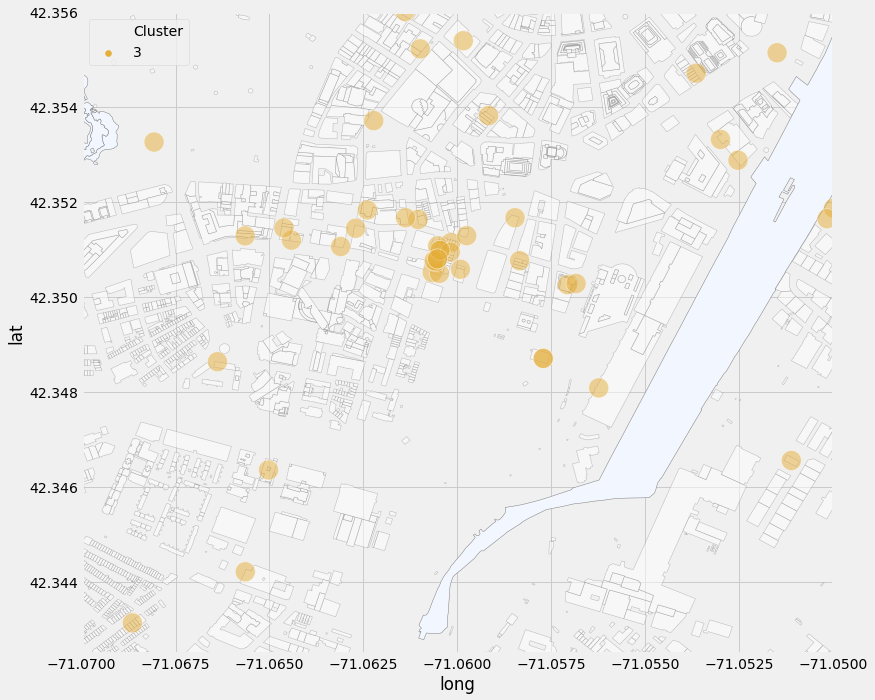

In [88]:
import geopandas as gpd
import pysal as ps
from pysal.contrib.viz import mapping as maps

palette=["C2"] #["C0", "C1", "k","C2"]

#figure size
plot_size = (12,11)

x_min = -71.07
y_min = 42.3425
x_max = -71.05
y_max = 42.356

building_shapefile_path = '../resources/boston_buildings.shp'
shapefile_path = '../resources/Hydrography_Polygon.shp'
building_shapefile = gpd.read_file(building_shapefile_path)
shapefile = gpd.read_file(shapefile_path) #shapefile of boston waterway

#configure shapefile projection
building_shapefile = building_shapefile.to_crs({'init': 'epsg:4326'}) 

clustered_data = pd.concat([plot_data, data_labels],axis=1)
fig, ax = plt.subplots(figsize=plot_size)

#define plot ranges
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

ax = building_shapefile.plot(ax=ax,alpha=.5,edgecolor='grey',facecolor='#ffffff')
ax = shapefile.plot(ax=ax,alpha=1,edgecolor='grey',facecolor='#f2f7ff')
sns.scatterplot(x='long',y='lat',data=clustered_data[clustered_data['Cluster']==3],hue='Cluster',s=400,palette=palette,alpha=.5)
plt.savefig("../data_archives/plot_exports/180824/cluster_plotcolor_3.jpg", dpi=300,
            papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None)

In [39]:
from scipy.stats import mode

venue_types = list(set(clustered_data['mapped_venue_type'].values))

c = []
d = []

for item in venue_types:
    v = item
    m = mode(clustered_data[clustered_data['mapped_venue_type']==item]['Cluster'])[0]
    c.append(v)
    d.append(m[0])

cluster_groups = pd.DataFrame({'type':c, 'cluster':d})
cluster_groups.sort_values(by='cluster')

type  cluster
0               education        0
5   professional_services        0
6              automotive        0
7              government        0
10        health_wellness        0
13                finance        0
1                    food        1
3                  retail        1
4                 grocery        1
8   culture_entertainment        1
12                  other        1
9          transportation        2
2                religous        3
11                    bar        3

In [41]:
seg_plot_data = true_centers.transpose()
seg_plot_data = seg_plot_data.reset_index()
seg_plot_data['Day'] = seg_plot_data['index']
seg_plot_data.drop('index',axis=1,inplace=True)

for i in range(len(seg_plot_data)):
    seg_plot_data.at[i,'Day'] = "{}_{}".format(i,seg_plot_data.loc[i]['Day'])
seg_plot_data

Segment 0  Segment 1  Segment 2  Segment 3          Day
0      473.0      428.0      812.0      181.0     0_Monday
1      565.0      439.0      838.0      217.0    1_Tuesday
2      540.0      429.0      829.0      200.0  2_Wednesday
3      549.0      467.0      837.0      247.0   3_Thursday
4      541.0      581.0      951.0      308.0     4_Friday
5      145.0      612.0      788.0      287.0   5_Saturday
6       39.0      509.0      668.0      195.0     6_Sunday

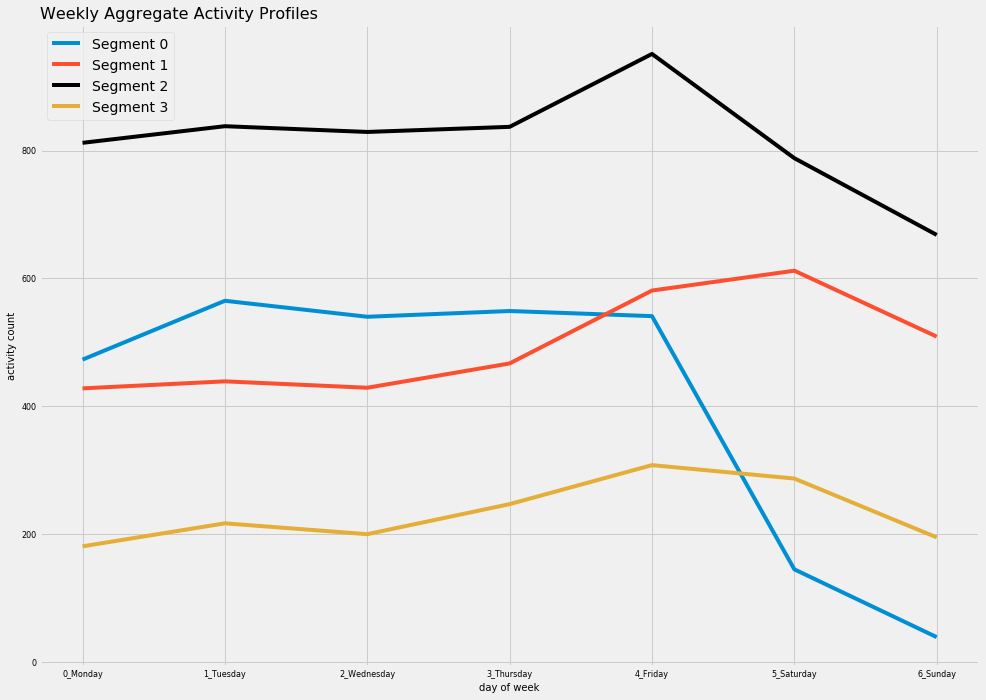

In [42]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,11))
sns.lineplot(x=seg_plot_data['Day'],y=seg_plot_data['Segment 0'],color=palette[0])
sns.lineplot(x=seg_plot_data['Day'],y=seg_plot_data['Segment 1'],color=palette[1])
sns.lineplot(x=seg_plot_data['Day'],y=seg_plot_data['Segment 2'],color=palette[2])
sns.lineplot(x=seg_plot_data['Day'],y=seg_plot_data['Segment 3'],color=palette[3])
plt.xticks(size=8)
plt.yticks(size=8)
plt.xlabel('day of week',fontsize=10)
plt.ylabel('activity count',fontsize=10)
plt.title('Weekly Aggregate Activity Profiles',fontsize=16, loc='left')
labels=seg_plot_data.columns
plt.legend(labels,loc='upper left')

plt.savefig("../data_archives/plot_exports/180824/cluster_pattern.jpg", dpi=300,
            papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None)

In [45]:
cluster_map = {'other':'1',
               'bar':'1',
               'food':'1',
               'religous':'1',
               'retail':'1',
               'culture_entertainment':'1',
               'transportation':'0',
               'grocery':'0',
               'health_wellness':'2',
               'government':'2',
               'automotive':'2',
               'professional_services':'2',
               'finance':'2',
               'education':'2'}
cluster_activity_map = {'0':{'Monday':718,'Tuesday':738,'Wednesday':729,'Thursday':745,'Friday':861,'Saturday':753,'Sunday':638},
                        '1':{'Monday':242,'Tuesday':236,'Wednesday':249,'Thursday':297,'Friday':387,'Saturday':429,'Sunday':334},
                        '2':{'Monday':443,'Tuesday':531,'Wednesday':506,'Thursday':519,'Friday':514,'Saturday':144,'Sunday':40},
                        '3':{'Monday':443,'Tuesday':455,'Wednesday':445,'Thursday':482,'Friday':597,'Saturday':621,'Sunday':518}}

In [46]:
df = pd.read_excel('../data_archives/df_processed.xlsx')
df.head()

index                        name        lat       long  \
0      0    McMahon & Associates, PC  42.352366 -71.056066   
1      1          Barclay Damon, LLP  42.352321 -71.056248   
2      2  Request Health Corporation  42.351584 -71.056269   
3      3                     StackUp  42.351586 -71.056323   
4      4                        KPMG  42.351781 -71.056737   

                     google_id  \
0  ChIJddqFA4Jw44kRHz6p3qWTs4c   
1  ChIJD75e1YBw44kRvDZoMEj44jY   
2  ChIJv1J9rnh644kR4hc29XVaEFg   
3  ChIJY_v-pXh744kRub1hj4RNwkk   
4  ChIJDaRRe4Jw44kRjXWBXIsFgj0   

                                          venue_type  Monday  Tuesday  \
0  ['accounting', 'lawyer', 'finance', 'point_of_...       0        0   
1  ['accounting', 'lawyer', 'finance', 'point_of_...       0        0   
2  ['accounting', 'finance', 'point_of_interest',...       0        0   
3  ['accounting', 'finance', 'point_of_interest',...       0        0   
4  ['accounting', 'finance', 'point_of_interest',...       0        0   

   Wednesday  Thursday  Friday  Saturday  Sunday  WeekTotals mapped_venue_type  
0          0         0       0         0       0           0           finance  
1          0         0       0         0       0           0           finance  
2          0         0       0         0       0           0           finance  
3          0         0       0         0       0           0           finance  
4          0         0       0         0       0           0           finance

In [47]:
ac = []
for i in range(len(df)):
    clust = cluster_map[df.iloc[i]['mapped_venue_type']]
    ac.append(clust)
    if df.loc[i]['WeekTotals'] == 0:
        df.at[i,'Monday'] = cluster_activity_map[clust]['Monday']
        df.at[i,'Tuesday'] = cluster_activity_map[clust]['Tuesday']
        df.at[i,'Wednesday'] = cluster_activity_map[clust]['Wednesday']
        df.at[i,'Thursday'] = cluster_activity_map[clust]['Thursday']
        df.at[i,'Friday'] = cluster_activity_map[clust]['Friday']
        df.at[i,'Saturday'] = cluster_activity_map[clust]['Saturday']
        df.at[i,'Sunday'] = cluster_activity_map[clust]['Sunday']
        df.at[i, 'WeekTotals'] = sum(df.iloc[i][['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']])

df['activity_cluster'] = ac    
df.head()

index                        name        lat       long  \
0      0    McMahon & Associates, PC  42.352366 -71.056066   
1      1          Barclay Damon, LLP  42.352321 -71.056248   
2      2  Request Health Corporation  42.351584 -71.056269   
3      3                     StackUp  42.351586 -71.056323   
4      4                        KPMG  42.351781 -71.056737   

                     google_id  \
0  ChIJddqFA4Jw44kRHz6p3qWTs4c   
1  ChIJD75e1YBw44kRvDZoMEj44jY   
2  ChIJv1J9rnh644kR4hc29XVaEFg   
3  ChIJY_v-pXh744kRub1hj4RNwkk   
4  ChIJDaRRe4Jw44kRjXWBXIsFgj0   

                                          venue_type  Monday  Tuesday  \
0  ['accounting', 'lawyer', 'finance', 'point_of_...     443      531   
1  ['accounting', 'lawyer', 'finance', 'point_of_...     443      531   
2  ['accounting', 'finance', 'point_of_interest',...     443      531   
3  ['accounting', 'finance', 'point_of_interest',...     443      531   
4  ['accounting', 'finance', 'point_of_interest',...     443      531   

   Wednesday  Thursday  Friday  Saturday  Sunday  WeekTotals  \
0        506       519     514       144      40        2697   
1        506       519     514       144      40        2697   
2        506       519     514       144      40        2697   
3        506       519     514       144      40        2697   
4        506       519     514       144      40        2697   

  mapped_venue_type activity_cluster  
0           finance                2  
1           finance                2  
2           finance                2  
3           finance                2  
4           finance                2

In [49]:
df.to_excel('../data_archives/df_processed.xlsx')

In [50]:
import pandas as pd

In [55]:
df = pd.read_excel('../data_archives/df_processed.xlsx')

In [56]:
set(df['activity_cluster'].values)

{0, 1, 2}

In [52]:
df

index                                               name        lat  \
0         0                           McMahon & Associates, PC  42.352366   
1         1                                 Barclay Damon, LLP  42.352321   
2         2                         Request Health Corporation  42.351584   
3         3                                            StackUp  42.351586   
4         4                                               KPMG  42.351781   
5         5                                 Baker Newman Noyes  42.353232   
6         6                         Adler Pollock & Sheehan PC  42.353291   
7         7                                Daigle & Associates  42.353588   
8         8                DGC (DiCicco, Gulman & Company LLP)  42.353649   
9         9                      Matson, Driscoll & Damico LLP  42.353653   
10       10             Jefferson Wells International - Boston  42.353755   
11       11                                     Meaden & Moore  42.353755   
12       12                       Rackemann, Sawyer & Brewster  42.354055   
13       13                                St Yves David A CPA  42.354035   
14       14                                            AAFCPAs  42.354074   
15       15    Soiref, Gary A CPA - Parent Mc Laughlin & Nagle  42.354075   
16       16   Kennedy James G Cpa - Parent Mc Laughlin & Nagle  42.354075   
17       17        Parent Mc Laughlin & Nagle: Ciampa John CPA  42.354075   
18       18                                          botkeeper  42.350304   
19       19                                     Edelstein & Co  42.354131   
20       20                                 A2 Global Shipping  42.350061   
21       21             Massachusetts General Hospital Helipad  42.363638   
22       22                      Boston City Hospital Heliport  42.333613   
23       23             Maverick St. Resident Gate East Boston  42.365290   
24       24                        Car rental , Boston Airport  42.368042   
25       25      Boston Logan International Airport Terminal B  42.362037   
26       26                                      Logan Airport  42.366134   
27       27  JetBlue Airways (Maintenance-Materials) Hangar...  42.374258   
28       28  Boston Logan International Airport - Terminal ...  42.366628   
29       29  Signature Flight Support BOS - Boston Logan In...  42.374899   
...     ...                                                ...        ...   
1693   5293                                    Highball Lounge  42.357395   
1694   5330                                    Shoppers' Plaza  42.356139   
1695   5331                           Norman B. Leventhal Park  42.356166   
1696   5333                                 Post Office Square  42.356514   
1697   5347                                        SP+ Parking  42.353565   
1698   5348                           99 Summer Street Parking  42.353591   
1699   5349                                        Parking Lot  42.353611   
1700   5353                                Kingston St Parking  42.353776   
1701   5390                                      Gary Drug Co.  42.357751   
1702   5392                       Afferent Pharmaceuticals Inc  42.352427   
1703   5404                  Kennedy Brothers Physical Therapy  42.355485   
1704   5453          Massachusetts State Police Marine Section  42.368127   
1705   5481                      Lincoln Street Property Owner  42.352726   
1706   5486                       Vesper Investment Properties  42.352999   
1707   5487                              A/E/C Solutions, Inc.  42.353055   
1708   5491                             GE Capital Real Estate  42.353100   
1709   5492                              Penrod Properties Inc  42.353075   
1710   5508                                           minigrow  42.353197   
1711   5510                             Chipotle Mexican Grill  42.353419   
1712   5513                                     Hot Pot Buffet  42.351289   
17

ValueError: The palette list has the wrong number of colors.

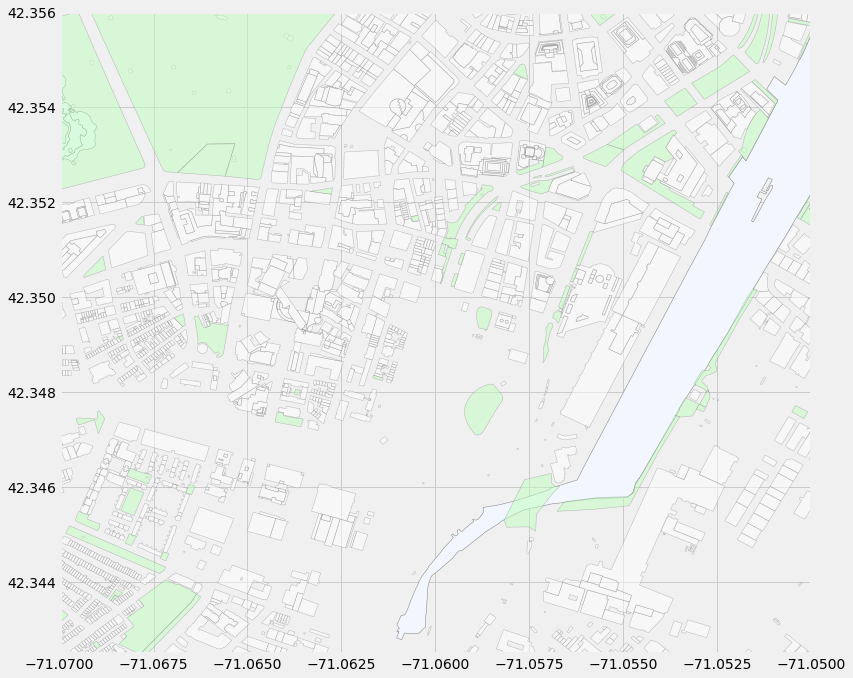

In [54]:
import geopandas as gpd
import pysal as ps
from pysal.contrib.viz import mapping as maps
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('fivethirtyeight')

palette=["C0", "C1", "k","C2"]

#figure size
plot_size = (12,11)

x_min = -71.07
y_min = 42.3425
x_max = -71.05
y_max = 42.356

building_shapefile_path = '../resources/boston_buildings.shp'
shapefile_path = '../resources/Hydrography_Polygon.shp'
open_space_path = '../resources/open_space.shp'
building_shapefile = gpd.read_file(building_shapefile_path)
shapefile = gpd.read_file(shapefile_path) #shapefile of boston waterway
open_space_shapefile = gpd.read_file(open_space_path)

#configure shapefile projection
building_shapefile = building_shapefile.to_crs({'init': 'epsg:4326'}) 
open_space_shapefile = open_space_shapefile.to_crs({'init': 'epsg:4326'})

#clustered_data = pd.concat([plot_data, data_labels],axis=1)
fig, ax = plt.subplots(figsize=plot_size)

#define plot ranges
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

#plot buildings
ax = building_shapefile.plot(ax=ax,alpha=.5,edgecolor='grey',facecolor='#ffffff')
#plot water
ax = shapefile.plot(ax=ax,alpha=1,edgecolor='grey',facecolor='#f2f7ff')
#plot open space
ax = open_space_shapefile.plot(ax=ax,alpha=.5,edgecolor='grey',facecolor='#bfffbf')
#plot venue locations
sns.scatterplot(x='long',y='lat',data=df,size='WeekTotals',hue='Cluster',sizes=(10, 1000),palette=palette,alpha=.5)
plt.legend(loc='upper left')
ax.legend_.remove()
plt.savefig("../data_archives/plot_exports/180824/cluster_plotcolor.jpg", dpi=300,
            papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None)
plt.title('Activity Profiles by Location',fontsize=16, loc='left')

In [13]:
len(df)

1723